In [1]:
!pip install matplotlib dtw
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import csv

from dtw import accelerated_dtw
from collections import defaultdict
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:

###################################
# 1) MODEL DEFINITION (SAME ARCH)
###################################
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.Wq = nn.Linear(hidden_dim, hidden_dim)
        self.Wk = nn.Linear(hidden_dim, hidden_dim)
        self.Wv = nn.Linear(hidden_dim, hidden_dim)
        self.scale = math.sqrt(hidden_dim)

    def forward(self, x):
        # x: (B, T, hidden_dim)
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn_scores = torch.bmm(Q, K.transpose(1, 2)) / self.scale  # (B, T, T)
        attn_weights = torch.softmax(attn_scores, dim=-1)           # (B, T, T)
        out = torch.bmm(attn_weights, V)                            # (B, T, hidden_dim)
        return out

class FewShotLSTMAttn(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=1):
        super().__init__()
        # difference vector: (B, 192) -> hidden_dim
        self.diff_to_hidden = nn.Linear(192, hidden_dim)

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.attention = SelfAttention(hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, test_past, support_past, support_future):
        """
        test_past:      (B, 192)
        support_past:   (B, 192)
        support_future: (B, 192, 1)
        returns:        (B, 192, 1)
        """
        diff_vec = test_past - support_past  # (B, 192)
        h0 = self.diff_to_hidden(diff_vec)   # (B, hidden_dim)
        c0 = torch.zeros_like(h0)            # (B, hidden_dim)

        h0 = h0.unsqueeze(0)  # => (1, B, hidden_dim)
        c0 = c0.unsqueeze(0)  # => (1, B, hidden_dim)

        lstm_out, (hn, cn) = self.lstm(support_future, (h0, c0))
        attn_out = self.attention(lstm_out)
        pred = self.fc_out(attn_out)
        return pred

In [7]:
###################################
# 2) LOAD TRAINED MODEL WEIGHTS
###################################
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate the same architecture used at training
model = FewShotLSTMAttn(hidden_dim=64, num_layers=1).to(device)

# Load the checkpoint (example file name)
model.load_state_dict(torch.load("few_shot_lstm_attn_epoch_55.pth", map_location=device))
model.eval()

FewShotLSTMAttn(
  (diff_to_hidden): Linear(in_features=192, out_features=64, bias=True)
  (lstm): LSTM(1, 64, batch_first=True)
  (attention): SelfAttention(
    (Wq): Linear(in_features=64, out_features=64, bias=True)
    (Wk): Linear(in_features=64, out_features=64, bias=True)
    (Wv): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
###################################
# 3) DATA LOADING & SPLITTING
###################################
def load_and_combine(csv_paths):
    df_list = []
    for path in csv_paths:
        temp_df = pd.read_csv(path, parse_dates=['timestamp'])
        temp_df.sort_values(by=['Station', 'timestamp'], inplace=True)
        df_list.append(temp_df)
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df.reset_index(drop=True, inplace=True)
    return combined_df

csv_files = [
    "../Data/training_data_january_2023.csv",
    "../Data/training_data_february_2023.csv"
]
full_df = load_and_combine(csv_files)

N = len(full_df)
train_end = int(0.70 * N)
support_end = int(0.85 * N)

train_df = full_df.iloc[:train_end].copy().reset_index(drop=True)
support_df = full_df.iloc[train_end:support_end].copy().reset_index(drop=True)
test_df   = full_df.iloc[support_end:].copy().reset_index(drop=True)

def create_4day_chunks(df_single_station):
    df_single_station = df_single_station.sort_values('timestamp').copy()
    df_single_station['date'] = df_single_station['timestamp'].dt.date
    
    day_groups = []
    for day, group in df_single_station.groupby('date'):
        day_groups.append((day, group.sort_values('timestamp')))
    
    chunks = []
    for i in range(len(day_groups) - 3):
        _, df0 = day_groups[i]
        _, df1 = day_groups[i+1]
        _, df2 = day_groups[i+2]
        _, df3 = day_groups[i+3]
        
        combined_df = pd.concat([df0, df1, df2, df3], ignore_index=True)
        combined_df = combined_df.sort_values('timestamp')
        
        if len(combined_df) == 384:
            flow_4days = combined_df['Total_Flow'].to_numpy()  # shape (384,)
            chunks.append(flow_4days)
    return chunks

def create_dataset_with_station_ids(df):
    all_chunks = []
    station_ids = []
    for sid in df['Station'].unique():
        sid_df = df[df['Station'] == sid]
        station_chunks = create_4day_chunks(sid_df)
        for ch in station_chunks:
            all_chunks.append(ch)      # shape (384,)
            station_ids.append(sid)
    return np.array(all_chunks), np.array(station_ids)

training_dataset, training_station_ids = create_dataset_with_station_ids(train_df)
support_dataset,  support_station_ids  = create_dataset_with_station_ids(support_df)
test_dataset,     test_station_ids     = create_dataset_with_station_ids(test_df)

###################################
# 4) NEAREST SUPPORT
###################################
def find_nearest_support(example_past, support_data):
    best_dist = float('inf')
    best_idx = 0
    for i, chunk in enumerate(support_data):
        support_past = chunk[:192]
        dist = np.linalg.norm(example_past - support_past)
        if dist < best_dist:
            best_dist = dist
            best_idx = i
    return best_idx



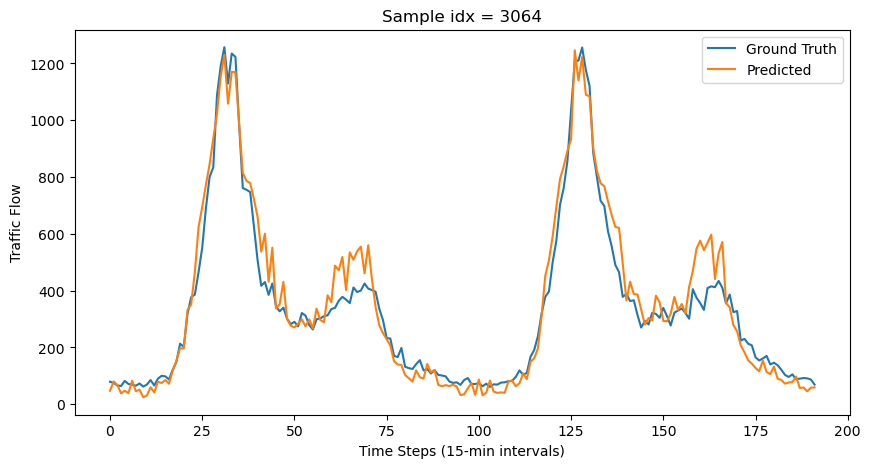

In [103]:
###################################
# 5) SINGLE SAMPLE INFERENCE
###################################
# Random sample from test dataset
sample_idx = np.random.randint(0, len(test_dataset))
test_chunk = test_dataset[sample_idx]  # shape (384,)

test_past  = test_chunk[:192]
test_future = test_chunk[192:]

# find nearest support
idx_support = find_nearest_support(test_past, support_dataset)
support_chunk = support_dataset[idx_support]
support_past   = support_chunk[:192]
support_future = support_chunk[192:]

# convert to Tensors
x_test_past = torch.tensor(test_past,     dtype=torch.float, device=device).unsqueeze(0)    # (1, 192)
x_supp_past = torch.tensor(support_past,  dtype=torch.float, device=device).unsqueeze(0)    # (1, 192)
y_supp_fut  = torch.tensor(support_future,dtype=torch.float, device=device).unsqueeze(0).unsqueeze(-1)  # (1, 192, 1)

# predict
with torch.no_grad():
    pred_future = model(x_test_past, x_supp_past, y_supp_fut) # => (1, 192, 1)

pred_future_np = pred_future.squeeze().cpu().numpy()  # shape (192,)

# Plot
plt.figure(figsize=(10,5))
plt.plot(test_future, label="Ground Truth")
plt.plot(pred_future_np, label="Predicted")
plt.title(f"Sample idx = {sample_idx}")
plt.xlabel("Time Steps (15-min intervals)")
plt.ylabel("Traffic Flow")
plt.legend()
plt.show()



Global MSE: 39606.1148199872
Global MAE: 123.50482543565069


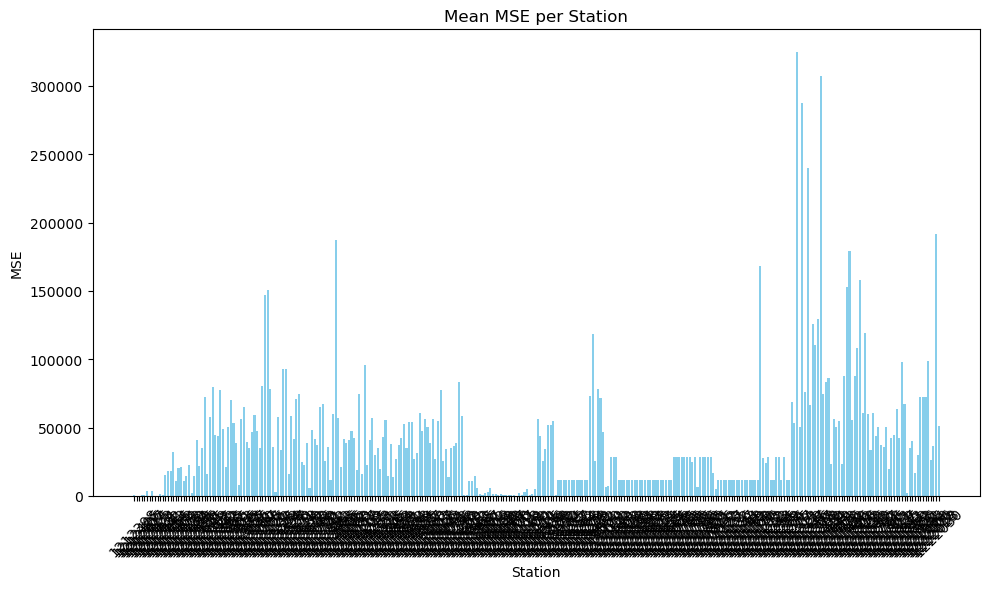

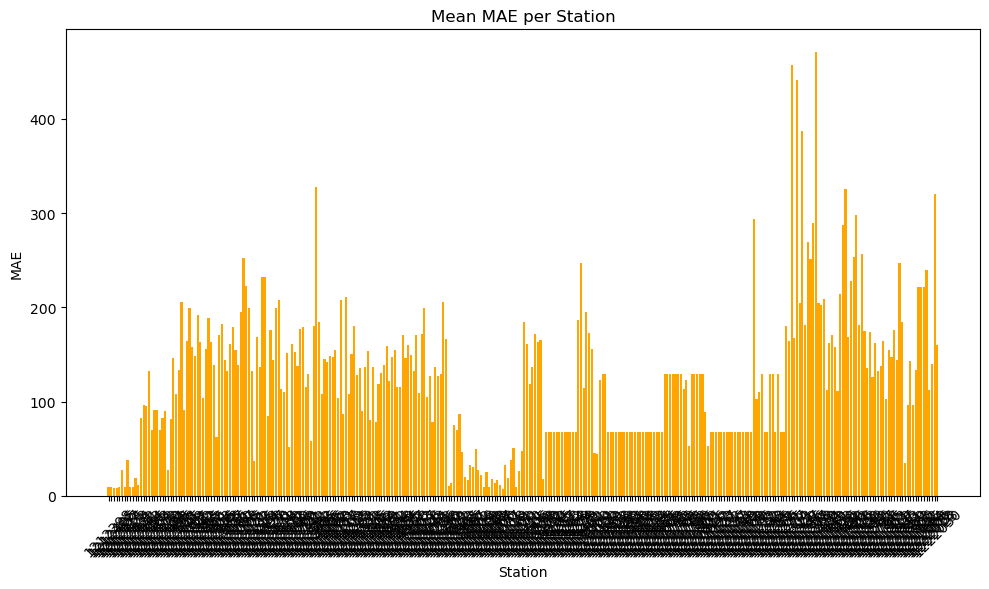

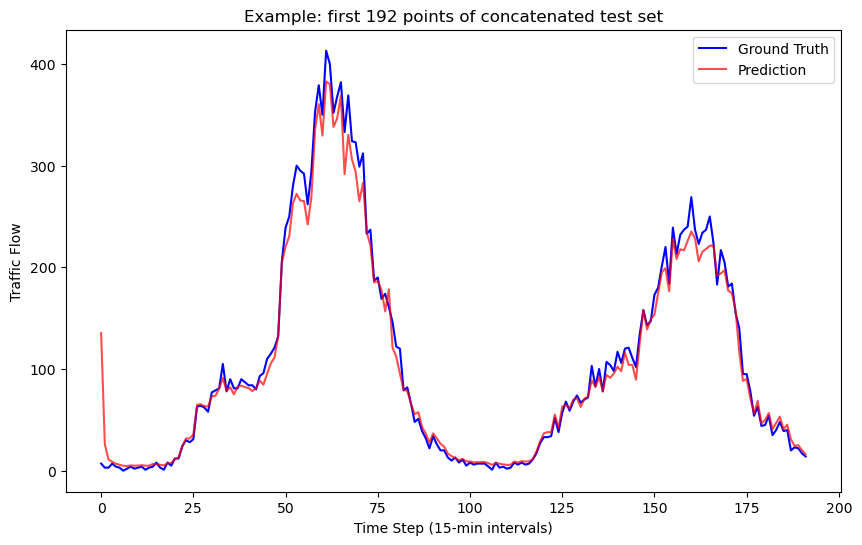

In [48]:
###################################
# 6) EVALUATION (ALL TEST CHUNKS)
###################################
station_mse_dict = defaultdict(list)
station_mae_dict = defaultdict(list)

all_preds = []
all_actual = []
all_station_labels = []

for i in range(len(test_dataset)):
    station_id = test_station_ids[i]
    chunk = test_dataset[i]
    test_past  = chunk[:192]
    test_future = chunk[192:]

    idx_support = find_nearest_support(test_past, support_dataset)
    support_chunk = support_dataset[idx_support]
    support_past   = support_chunk[:192]
    support_future = support_chunk[192:]

    x_test_past = torch.tensor(test_past,    dtype=torch.float, device=device).unsqueeze(0)
    x_supp_past = torch.tensor(support_past, dtype=torch.float, device=device).unsqueeze(0)
    y_supp_fut  = torch.tensor(support_future,dtype=torch.float,device=device).unsqueeze(0).unsqueeze(-1)

    with torch.no_grad():
        y_pred = model(x_test_past, x_supp_past, y_supp_fut)  # => (1, 192, 1)

    y_pred_np = y_pred.squeeze().cpu().numpy()    # (192,)
    # compute metrics
    chunk_mse = mean_squared_error(test_future, y_pred_np)
    chunk_mae = mean_absolute_error(test_future, y_pred_np)

    station_mse_dict[station_id].append(chunk_mse)
    station_mae_dict[station_id].append(chunk_mae)

    all_preds.append(y_pred_np)
    all_actual.append(test_future)
    all_station_labels.append(station_id)

all_preds   = np.concatenate(all_preds)
all_actual  = np.concatenate(all_actual)

global_mse = mean_squared_error(all_actual, all_preds)
global_mae = mean_absolute_error(all_actual, all_preds)
print("Global MSE:", global_mse)
print("Global MAE:", global_mae)

station_ids_unique = sorted(station_mse_dict.keys())
station_mse_mean = [np.mean(station_mse_dict[sid]) for sid in station_ids_unique]
station_mae_mean = [np.mean(station_mae_dict[sid]) for sid in station_ids_unique]

plt.figure(figsize=(10,6))
plt.bar(range(len(station_ids_unique)), station_mse_mean, color='skyblue')
plt.xticks(range(len(station_ids_unique)), station_ids_unique, rotation=45)
plt.title("Mean MSE per Station")
plt.xlabel("Station")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.bar(range(len(station_ids_unique)), station_mae_mean, color='orange')
plt.xticks(range(len(station_ids_unique)), station_ids_unique, rotation=45)
plt.title("Mean MAE per Station")
plt.xlabel("Station")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(all_actual[:192], label='Ground Truth', color='blue')
plt.plot(all_preds[:192],  label='Prediction',   color='red', alpha=0.7)
plt.title("Example: first 192 points of concatenated test set")
plt.xlabel("Time Step (15-min intervals)")
plt.ylabel("Traffic Flow")
plt.legend()
plt.show()